# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [0]:
!mkdir ./datasets
!mkdir ./datasets/cat_brain
!wget -O ./datasets/cat_brain/mixed.species_brain_1.graphml https://s3.amazonaws.com/connectome-graphs/cat/mixed.species_brain_1.graphml
!ls ./datasets/cat_brain

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/cat_brain’: File exists
--2020-05-03 10:42:13--  https://s3.amazonaws.com/connectome-graphs/cat/mixed.species_brain_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.140.6
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.140.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58516 (57K) [binary/octet-stream]
Saving to: ‘./datasets/cat_brain/mixed.species_brain_1.graphml’

./datasets/cat_brai 100%[===================>]  57.14K  --.-KB/s    in 0.03s   

2020-05-03 10:42:14 (2.16 MB/s) - ‘./datasets/cat_brain/mixed.species_brain_1.graphml’ saved [58516/58516]

mixed.species_brain_1.graphml


In [0]:
!pip install turicreate
!pip install karateclub

     |████████████████████████████████| 91.8MB 83kB/s 
     |████████████████████████████████| 327kB 44.7MB/s 
     |████████████████████████████████| 3.4MB 43.7MB/s 
     |████████████████████████████████| 86.3MB 46kB/s 
     |████████████████████████████████| 3.8MB 45.6MB/s 
     |████████████████████████████████| 450kB 46.8MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=542fb45a367b8c2f4a696cfea730ba3f4f7ab3b7558963a5988073c55c5f3a5e
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=df0791f3ffd51e28d72c71399201a18900a3055adce4a479417ec5fea04d4bd7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
 

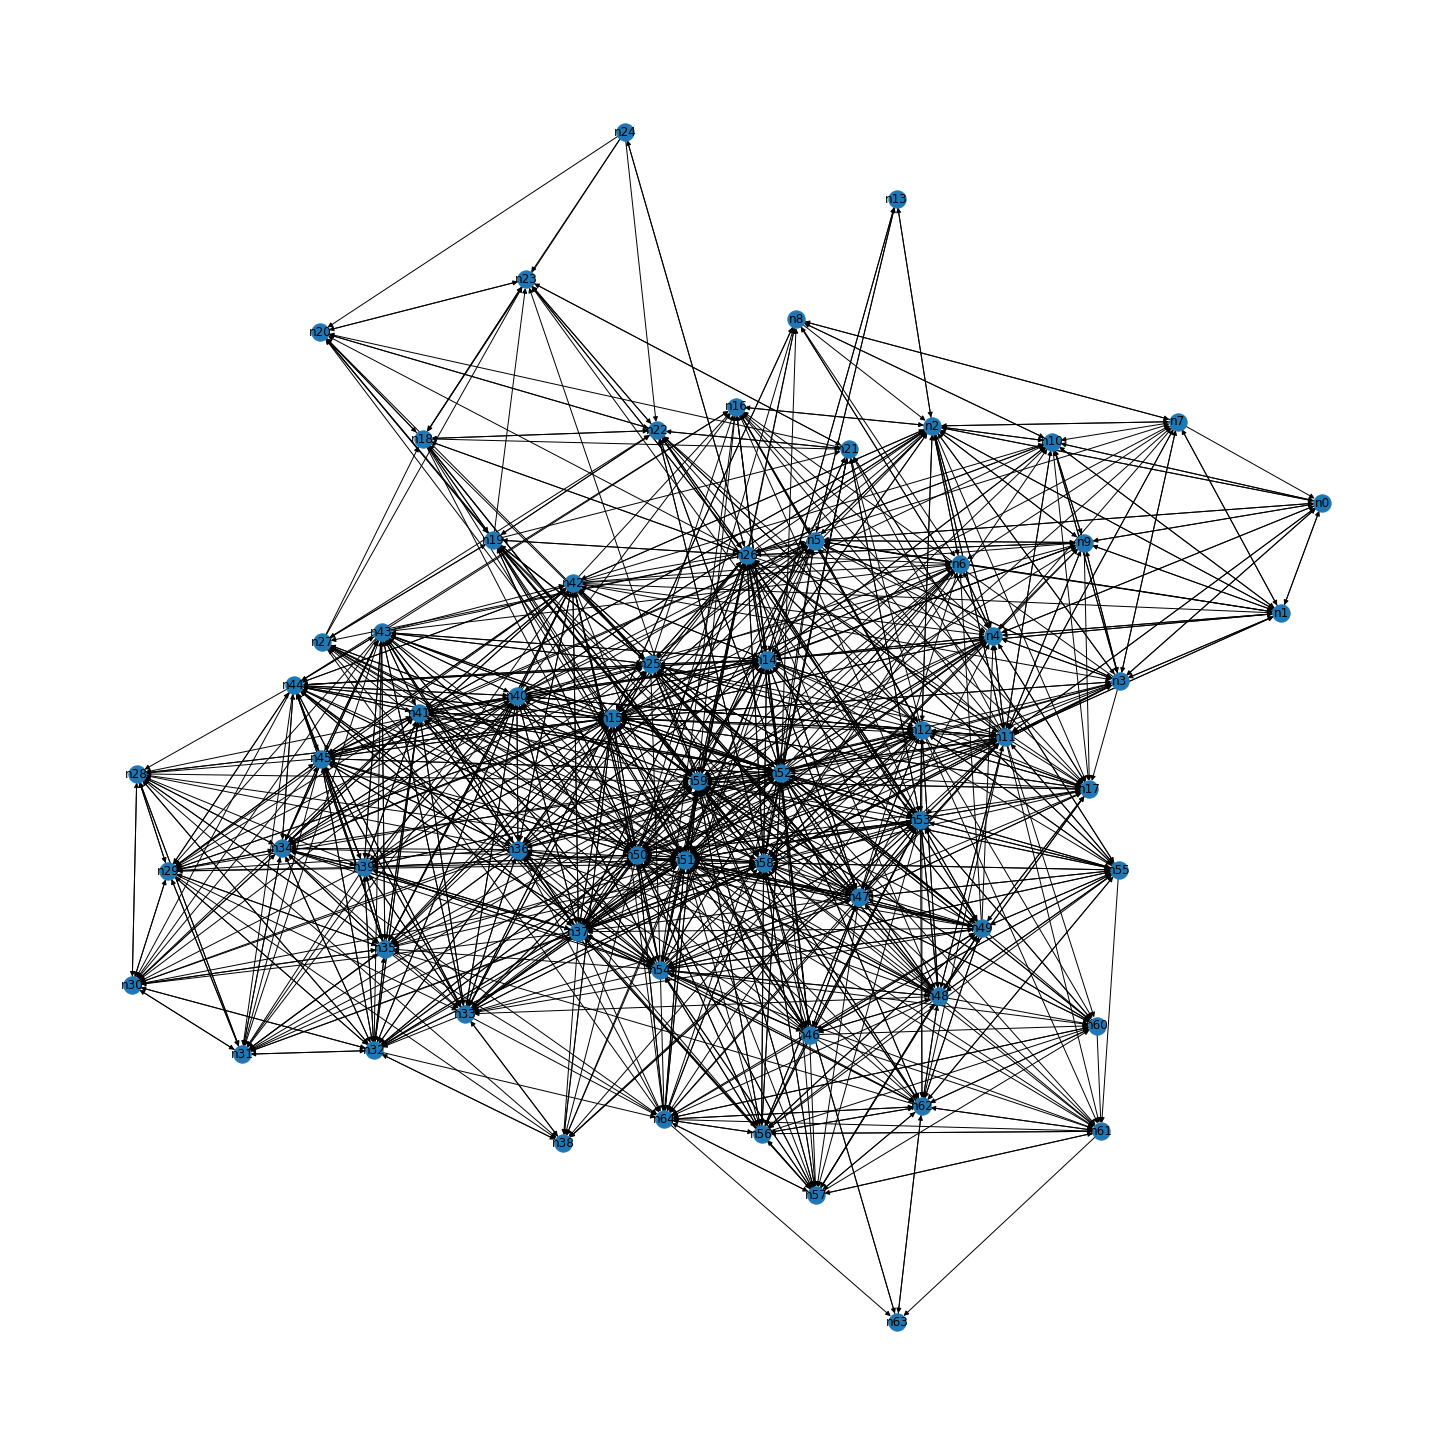

In [181]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

g = nx.read_graphml('./datasets/cat_brain/mixed.species_brain_1.graphml')

plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(g, with_labels=True)

In [182]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 65\nNumber of edges: 1139\nAverage in degree:  17.5231\nAverage out degree:  17.5231'

In [0]:
# This is for predicting missing links scenario
import random 

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]


def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))


def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)

def get_random_friend_of_friend(g, v, max_tries=100):
    for i in range(max_tries):
        u = random.choice(list(g.neighbors(v)))
        x = random.choice(list(g.neighbors(u)))
        if not g.has_edge(v,x):
            return x
    return None


def select_random_non_existing_links_distance_2(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        v = random.choice(v_list)
        u = get_random_friend_of_friend(g, v)
        if u is None:
            continue
        select_links.add((v,u))
    return list(select_links)

In [0]:
import operator
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set
    
def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v_in': g.in_degree(v),
            'degree_u_in': g.in_degree(u),
            'degree_v_out': g.out_degree(v),
            'degree_u_out': g.out_degree(u),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),           
            'friends_measure': friends_measure(g, u,v)
        }
    except Exception as e:
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None
    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

def get_links_features(g, postive_links, negative_links):
    links_features = []

    for i in range(len(postive_links)):    
        u,v = postive_links[i]
        d = get_features_dict(g, u,v )
        if d is None:
            continue
        d['class'] = True
        links_features.append(d)

    for i in range(len(negative_links)):    
        u,v = negative_links[i]
        d = get_features_dict(g, u,v )
        if d is None:
            continue
        d['class'] = False
        links_features.append(d)
    return links_features

Create vectors embedding for graph nodes

In [45]:
import karateclub

l =  list(zip(g.nodes(), range(len(g.nodes()))))
nodes_dict = dict(l)
r_node_dict = {v:k for k,v in nodes_dict.items()}
h = nx.Graph()
for e1,e2 in g.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])

model = karateclub.DeepWalk()

model.fit(h)
embedding = model.get_embedding()

array([[ 0.06528091,  0.04542477, -0.15552163, ..., -0.02591112,
         0.15770368,  0.07220861],
       [ 0.06617308,  0.05594935, -0.17384963, ..., -0.03421037,
         0.1606561 ,  0.07366312],
       [ 0.0720559 ,  0.06940402, -0.1868213 , ..., -0.03246916,
         0.16010195,  0.06655139],
       ...,
       [ 0.03043788,  0.03780733, -0.147825  , ..., -0.03347312,
         0.15772004,  0.10800514],
       [ 0.03572217,  0.03526951, -0.1350993 , ..., -0.02677721,
         0.13211192,  0.08641268],
       [ 0.03618708,  0.02729329, -0.1423222 , ..., -0.03659751,
         0.17276245,  0.12888694]], dtype=float32)

In [0]:
import numpy as np

def get_edge_embedding(u_embedding, v_embedding):
  return u_embedding+v_embedding


def get_features_dict_with_embedding(g,u, v, embedding, nodes_dict):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v_in': g.in_degree(v),
            'degree_u_in': g.in_degree(u),
            'degree_v_out': g.out_degree(v),
            'degree_u_out': g.out_degree(u),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),           
            'friends_measure': friends_measure(g, u,v)
        }
        u_embedding = embedding[nodes_dict[u]]
        v_embedding = embedding[nodes_dict[v]]
        edge_embedding = get_edge_embedding(u_embedding, v_embedding)
        edge_embedding_dict = dict(zip(['embedding_{}'.format(i) for i in range(0,len(edge_embedding))], edge_embedding))
        d = {**d, **edge_embedding_dict}
    except Exception as e:
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

def get_links_features_with_embedding(g, postive_links, negative_links, embedding, nodes_dict):
    links_features = []

    for i in range(len(postive_links)):    
        u,v = postive_links[i]
        d = get_features_dict_with_embedding(g, u,v, embedding, nodes_dict)
        if d is None:
            continue
        d['class'] = True
        links_features.append(d)

    for i in range(len(negative_links)):    
        u,v = negative_links[i]
        d = get_features_dict_with_embedding(g, u,v ,embedding, nodes_dict)
        if d is None:
            continue
        d['class'] = False
        links_features.append(d)
    return links_features



Create classifier from graph features

In [199]:
import turicreate as tc
def get_train_and_test(features_list, links_features):
    data_dict = {f:[] for f in features_list}
    for d in links_features:
      for feature in features_list:
          data_dict[feature].append(d[feature])
    sf = tc.SFrame(data_dict)
    test, train  = sf.random_split(0.2)
    print(f"Train size {len(train)}\nTest size: {len(test)}" )
    return train,test

def get_classifier(train, features_list):
    cls = tc.classifier.create(train,features=features_list, target="class")
    return cls

postive_links = select_random_existing_links(g,300)
negative_links = select_random_non_existing_links(g,300)

features_list = ['degree_v_in', 'degree_u_in', 'degree_v_out', 'degree_u_out', 'total_friends', 'common_friends', 'friends_measure', 'class']
features_list += ['embedding_{}'.format(i) for i in range(0,embedding.shape[1])]

links_features = get_links_features_with_embedding(g, postive_links, negative_links, embedding, nodes_dict)
train, test = get_train_and_test(features_list, links_features)
only_graph_features_list = ['degree_v_in', 'degree_u_in', 'degree_v_out', 'degree_u_out', 'total_friends', 'common_friends', 'friends_measure']
only_graph_features_cls = get_classifier(train, only_graph_features_list)

Train size 472
Test size: 128
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.002112     | 0.910714          | 0.875000            | 0.539209          | 0.563627            |

| 2         | 0.003720     | 0.904018          | 0.833333            | 0.448747          | 0.492667            |

| 3         | 0.005696     | 0.912946          | 0.875000            | 0.376097          | 0.445843            |

| 4         | 0.008654     | 0.926339          | 0.875000            | 0.322634          | 0.416538            |

| 5         | 0.010322     | 0.946429          | 0.833333            | 0.269680          | 0.380708            |

| 10        | 0.025801     | 0.977679          | 0.791667            | 0.161591          | 0.362087            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.009219     | 0.872768          | 0.750000            | 0.393287          | 0.577903            |

| 2         | 0.011004     | 0.877232          | 0.750000            | 0.375534          | 0.476928            |

| 3         | 0.013046     | 0.883929          | 0.791667            | 0.366686          | 0.484837            |

| 4         | 0.014851     | 0.892857          | 0.750000            | 0.363115          | 0.478472            |

| 5         | 0.019089     | 0.895089          | 0.750000            | 0.359386          | 0.475252            |

| 10        | 0.037911     | 0.888393          | 0.708333            | 0.360010          | 0.475783            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.008202     | 0.910714          | 0.875000            | 0.341666          | 0.414570            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.012943     | 0.508929          | 0.333333            |

| 1         | 4        | 1.000000  | 0.015343     | 0.515625          | 0.333333            |

| 2         | 5        | 1.000000  | 0.017330     | 0.750000          | 0.791667            |

| 3         | 10       | 0.083589  | 0.021842     | 0.741071          | 0.875000            |

| 4         | 18       | 6.615365  | 0.031434     | 0.756696          | 0.833333            |

| 9         | 28       | 1.000000  | 0.044997     | 0.785714          | 0.833333            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients      : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.002836     | 0.774554          | 0.833333            |

| 2         | 3        | 0.003986     | 0.779018          | 0.875000            |

| 3         | 4        | 0.005112     | 0.787946          | 0.875000            |

| 4         | 5        | 0.006364     | 0.787946          | 0.875000            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.7916666666666666
PROGRESS: RandomForestClassifier          : 0.7083333333333334
PROGRESS: DecisionTreeClassifier          : 0.875
PROGRESS: SVMClassifier                   : 0.8333333333333334
PROGRESS: LogisticClassifier              : 0.875
PROGRESS: ---------------------------------------------
PROGRESS: Selecting DecisionTreeClassifier based on validation set performance.


Evaluate classifier from graph features

In [200]:
results = only_graph_features_cls.evaluate(test)
results

{'accuracy': 0.75, 'auc': 0.815673828125, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   11  |
 |      1       |        1        |   53  |
 |      0       |        1        |   21  |
 |      0       |        0        |   43  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.7681159420289855, 'log_loss': 0.537336423185149, 'precision': 0.7162162162162162, 'recall': 0.828125, 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+----+----+
 | threshold | fpr | tpr | p  | n  |
 +-----------+-----+-----+----+----+
 |    0.0    | 1.0 | 1.0 | 64 | 64 |
 |   1e-05   | 1.0 | 1.0 | 64 | 64 |
 |   2e-05   | 1.0 | 1.0 | 64 | 64 |
 |   3e-05   | 1.0 | 1.0 | 64 | 64 |
 

Create classifier with graph features and node embedding sum.

In [201]:
with_embedding_features_list = ['degree_v_in', 'degree_u_in', 'degree_v_out', 'degree_u_out', 'total_friends', 'common_friends', 'friends_measure']
with_embedding_features_list += ['embedding_{}'.format(i) for i in range(0,embedding.shape[1])]
cls_with_embedding = get_classifier(train, with_embedding_features_list)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 135

Number of unpacked features : 135

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.015083     | 0.897321          | 0.833333            | 0.537217          | 0.563110            |

| 2         | 0.029002     | 0.919643          | 0.791667            | 0.425909          | 0.504474            |

| 3         | 0.042090     | 0.948661          | 0.916667            | 0.347456          | 0.450660            |

| 4         | 0.054487     | 0.979911          | 0.791667            | 0.277804          | 0.432544            |

| 5         | 0.066296     | 0.986607          | 0.916667            | 0.229860          | 0.413482            |

| 10        | 0.116038     | 0.997768          | 0.875000            | 0.106466          | 0.416349            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 135

Number of unpacked features : 135

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.009496     | 0.879464          | 0.833333            | 0.365993          | 0.395154            |

| 2         | 0.017176     | 0.881696          | 0.875000            | 0.345030          | 0.425513            |

| 3         | 0.025513     | 0.904018          | 0.875000            | 0.336042          | 0.409651            |

| 4         | 0.033943     | 0.915179          | 0.833333            | 0.329152          | 0.444938            |

| 5         | 0.043168     | 0.933036          | 0.833333            | 0.314698          | 0.457440            |

| 10        | 0.080784     | 0.946429          | 0.833333            | 0.307133          | 0.410333            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 135

Number of unpacked features : 135

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.015397     | 0.897321          | 0.833333            | 0.338453          | 0.442369            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 135

Number of unpacked features : 135

Number of coefficients    : 136

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 0.041114     | 0.549107          | 0.291667            |

| 1         | 7        | 1.250000  | 0.058689     | 0.569196          | 0.416667            |

| 2         | 12       | 0.966173  | 0.081086     | 0.595982          | 0.583333            |

| 3         | 13       | 1.000000  | 0.091174     | 0.600446          | 0.625000            |

| 4         | 14       | 1.000000  | 0.100177     | 0.676339          | 0.500000            |

| 9         | 21       | 1.000000  | 0.145006     | 0.747768          | 0.875000            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 448

Number of classes           : 2

Number of feature columns   : 135

Number of unpacked features : 135

Number of coefficients      : 136

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.057594     | 0.828125          | 0.916667            |

| 2         | 3        | 0.080799     | 0.839286          | 0.916667            |

| 3         | 4        | 0.100777     | 0.834821          | 0.916667            |

| 4         | 5        | 0.124987     | 0.834821          | 0.916667            |

| 5         | 6        | 0.145539     | 0.834821          | 0.916667            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.875
PROGRESS: RandomForestClassifier          : 0.8333333333333334
PROGRESS: DecisionTreeClassifier          : 0.8333333333333334
PROGRESS: SVMClassifier                   : 0.875
PROGRESS: LogisticClassifier              : 0.9166666666666666
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


Evaluate classifier with embedding features

In [202]:
results = cls_with_embedding.evaluate(test)
results

{'accuracy': 0.7109375, 'auc': 0.779296875, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   18  |
 |      1       |        1        |   46  |
 |      0       |        1        |   19  |
 |      0       |        0        |   45  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.7131782945736435, 'log_loss': 0.7202371285123299, 'precision': 0.7076923076923077, 'recall': 0.71875, 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+----+----+
 | threshold | fpr | tpr | p  | n  |
 +-----------+-----+-----+----+----+
 |    0.0    | 1.0 | 1.0 | 64 | 64 |
 |   1e-05   | 1.0 | 1.0 | 64 | 64 |
 |   2e-05   | 1.0 | 1.0 | 64 | 64 |
 |   3e-05   | 1.0 | 1.0 | 64 | 64 |

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [100]:
!mkdir ./datasets
!mkdir ./datasets/enron
!wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/
!wget -O ./datasets/enron/roles.txt http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt
!ls ./datasets/enron

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_documents/1694.
maildir/campbell-l/all_documents/1613.
maildir/campbell-l/all_doc

Get managers list from source

In [140]:
import re

def parse_enron_employee():
  manager_roles = ['Vice President', 'President', 'Manager', 'CEO', 'Managing Director']
  mail_index = 0
  fullname_index = 1
  role_index = 2
  extra_info_inde = 3
  managers_list = []
  for line in open('./datasets/enron/roles.txt', "r", encoding='utf8', errors='ignore').readlines():
    line_info = re.split('\t |  |\t|\n',line)
    line_info = [info for info in line_info if info!=""]
    if len(line_info) > role_index:
      if line_info[role_index] in manager_roles:
        managers_list.append(line_info[mail_index])
  return managers_list

managers_list = parse_enron_employee()
managers_list

['andy.zipper',
 'barry.tycholiz',
 'danny.mccarty',
 'daren.farmer',
 'd..steffes',
 'e..haedicke',
 'fletcher.sturm',
 'harry.arora',
 'hunter.shively',
 'james.steffes',
 'jane.tholt',
 'jeffrey.hodge',
 'jeff.skilling',
 'j..farmer',
 'j..kaminski',
 'j.kaminski',
 'j..kean',
 'john.forney',
 'john.hodge',
 'john.lavorato',
 'john.zufferli',
 'j..sturm',
 'k..allen',
 'kevin.presto',
 'louise.kitchen',
 'mark.e.haedicke',
 'mark.haedicke',
 'm..forney',
 'm..presto',
 'm..tholt',
 'phillip.allen',
 'richard.shapiro',
 'rick.buy',
 'scott.neal',
 's..shively',
 'steven.kean',
 'teb.lokey',
 't..hodge',
 'vince.kaminski']

In [101]:
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm 

enron_data_set_path = "./datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

Found 99279 files


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [142]:
import networkx as nx

g = nx.DiGraph()
g.add_edges_from(links)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 18590
Number of edges: 32392
Average in degree:   1.7424
Average out degree:   1.7424


Evaluate the precision of centrality algorithms to identify managers at Enron. 

In [177]:
import operator

def get_manager_precision(managers_list, top_10_employee):
  tpr = 0
  for employee in top_10_employee:
    employee_mail_name = employee[0].split('@')[0]
    if employee_mail_name in managers_list:
      tpr+=1
  return tpr/len(top_10_employee)

degree_centrality_employees = sorted(dict(nx.degree_centrality(g)).items(), key=operator.itemgetter(1), reverse=True)
top_10_degree_centrality_employees = degree_centrality_employees[:10]
degree_centrality_precision = get_manager_precision(managers_list, top_10_degree_centrality_employees)
print('precision of degree_centrality method to find managers is: {}'.format(degree_centrality_precision))

closeness_centrality_employees = sorted(dict(nx.closeness_centrality(g)).items(), key=operator.itemgetter(1), reverse=True)
top_10_closeness_centrality_employees = closeness_centrality_employees[:10]
closeness_centrality_precision = get_manager_precision(managers_list, top_10_closeness_centrality_employees)
print('precision of closeness_centrality method to find managers is: {}'.format(closeness_centrality_precision))

betweenness_centrality_employees = sorted(dict(nx.betweenness_centrality(g)).items(), key=operator.itemgetter(1), reverse=True)
top_10_betweenness_centrality_employees = betweenness_centrality_employees[:10]
betweenness_centrality_precision = get_manager_precision(managers_list, top_10_betweenness_centrality_employees)
print('precision of betweenness_centrality method to find managers is: {}'.format(betweenness_centrality_precision))

precision of degree_centrality method to find managers is: 0.2
precision of closeness_centrality method to find managers is: 0.5
precision of betweenness_centrality method to find managers is: 0.2


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

l = [employee[0] for employee in closeness_centrality_employees[:100]]
h = g.subgraph(l)
colors = []
for node in h.nodes():
  employee_mail_name = node.split('@')[0]
  if employee_mail_name in managers_list:
    colors.append('red')
  else:
    colors.append('blue')

top_100_centrality = dict(nx.closeness_centrality(h))

Top 100 employee of closeness centrality method, manegers colored with red, size of nodes determine by closeness centrality.

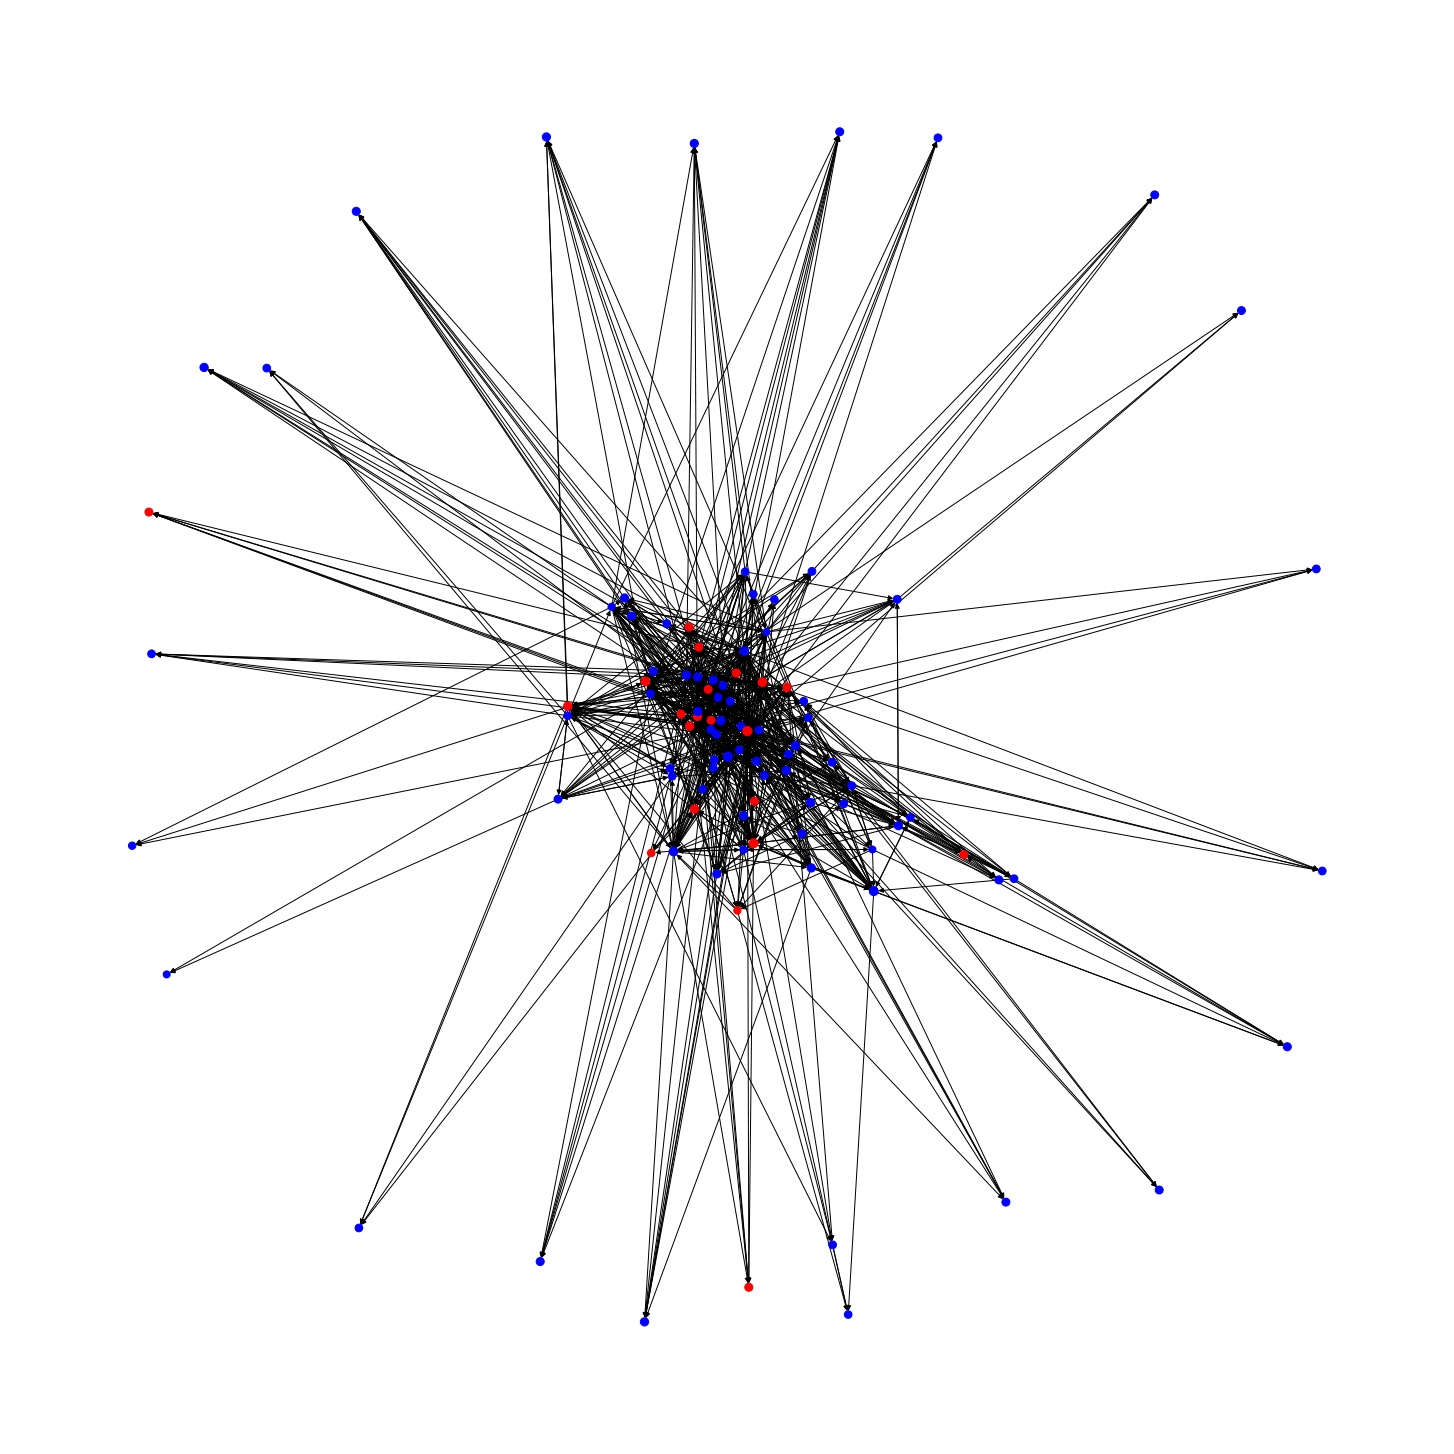

In [178]:
plt.figure(figsize=(20,20))

nx.draw_spring(h,node_color =colors, node_size = [top_100_centrality[n]*200 for n in h.nodes()], 
               font_size = 6, with_labels = False)